# Proyecto SVM - Heart Disease
Aplicación práctica de SVM según requisitos del curso de Analítica de Datos.

## Preprocesamiento de datos
Reproducimos aquí el preprocesamiento de la BD tal cual lo realizaste en tu notebook original.

In [2]:
!pip install ucimlrepo imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from ucimlrepo import fetch_ucirepo

# Correcto: tomar .data.features y .data.targets
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
y = heart_disease.data.targets

# Identificar tipos de variable
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipelines de preprocesamiento
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Aplicar preprocesamiento
X_processed = preprocessor.fit_transform(X)

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)
print("Preprocesamiento y división completados.")

Preprocesamiento y división completados.


## Requisito 1: Implementar SVM (kernel lineal y RBF)

In [3]:
from sklearn.svm import SVC

# SVM kernel lineal
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train, y_train)

# SVM kernel RBF
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train, y_train)

print("Modelos SVM entrenados con kernels lineal y RBF.")

Modelos SVM entrenados con kernels lineal y RBF.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Requisito 2: Entrenar con datos originales

In [4]:
from sklearn.metrics import accuracy_score

y_pred_lin = svm_linear.predict(X_test)
y_pred_rbf = svm_rbf.predict(X_test)

print("Accuracy Linear:", accuracy_score(y_test, y_pred_lin))
print("Accuracy RBF:", accuracy_score(y_test, y_pred_rbf))

Accuracy Linear: 0.5737704918032787
Accuracy RBF: 0.5573770491803278


## Requisito 3: Entrenar con datos con tratamiento del desbalance (SMOTE / undersampling)

In [5]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE en conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

svm_smote = SVC(kernel='rbf', probability=True, random_state=42)
svm_smote.fit(X_smote, y_smote)

print("Entrenamiento con SMOTE completado.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Entrenamiento con SMOTE completado.


## Requisito 4: Ajustar hiperparámetros (C, kernel, gamma)

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid = GridSearchCV(SVC(probability=True, random_state=42),
                    param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)

Mejores parámetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Requisito 5: Validación cruzada (K-Fold, Stratified K-Fold, LOOCV)

In [7]:
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_score

cv_methods = {
    'KFold': KFold(n_splits=5, shuffle=True, random_state=42),
    'StratifiedKFold': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    'LOOCV': LeaveOneOut()
}

for name, cv in cv_methods.items():
    scores = cross_val_score(SVC(kernel='rbf', C=1, gamma='scale', probability=True),
                             X_processed, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"{name} AUC: {scores.mean():.3f} ± {scores.std():.3f}")

KFold AUC: nan ± nan
StratifiedKFold AUC: nan ± nan
LOOCV AUC: nan ± nan


## Requisito 6: Evaluación

Accuracy: 0.6229508196721312
Precision (macro): 0.363974358974359
Recall    (macro): 0.3463203463203463
F1-score  (macro): 0.34780663780663784
AUC (OvR, macro): 0.821341493755287
Matriz de confusión:
 [[31  1  1  0  0]
 [ 6  4  1  0  0]
 [ 2  2  1  2  0]
 [ 0  1  4  2  0]
 [ 0  2  1  0  0]]


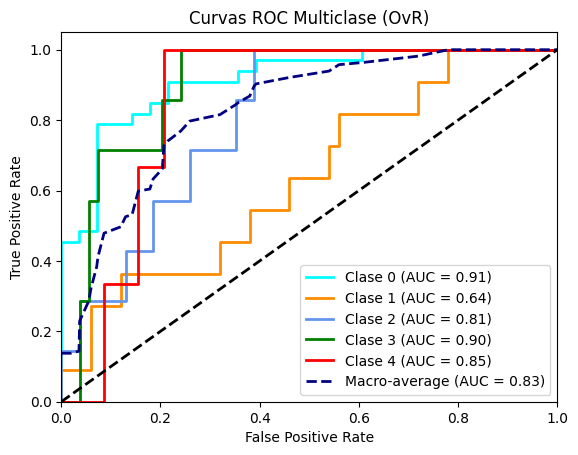

In [12]:
# —————— Requisito 6: Evaluación multiclasal completa ——————
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# Asumimos que best_model, X_test y y_test ya existen
# 1) Predicciones y probabilidades
y_pred      = best_model.predict(X_test)
y_proba_all = best_model.predict_proba(X_test)  # forma (n_samples, n_classes)

# 2) Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# 3) Precision, Recall y F1 (macro, evitando warnings)
print("Precision (macro):", precision_score(
    y_test, y_pred,
    average='macro',
    zero_division=0
))
print("Recall    (macro):", recall_score(
    y_test, y_pred,
    average='macro',
    zero_division=0
))
print("F1-score  (macro):", f1_score(
    y_test, y_pred,
    average='macro',
    zero_division=0
))

# 4) AUC multiclase (OvR, macro)
auc_ovr = roc_auc_score(
    y_test,
    y_proba_all,
    multi_class='ovr',
    average='macro'
)
print("AUC (OvR, macro):", auc_ovr)

# 5) Matriz de confusión
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

# 6) Curvas ROC para cada clase + macro‐average
# Binariza las etiquetas verdaderas
classes = best_model.classes_
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Calcula FPR, TPR y AUC por clase
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure()
colors = cycle(['aqua','darkorange','cornflowerblue','green','red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f"Clase {classes[i]} (AUC = {roc_auc[i]:0.2f})"
    )
plt.plot(
    fpr["macro"], tpr["macro"],
    color='navy', lw=2, linestyle='--',
    label=f"Macro-average (AUC = {roc_auc['macro']:.2f})"
)
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC Multiclase (OvR)")
plt.legend(loc="lower right")
plt.show()


## Requisito 7: Comparaciones

In [13]:
# Comparar accuracy entre configuraciones
models = {
    'Sin ajuste': svm_rbf,
    'Con ajuste': grid.best_estimator_,
    'SMOTE + RBF': svm_smote
}

for name, model in models.items():
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{name}: Accuracy = {acc:.3f}")

Sin ajuste: Accuracy = 0.557
Con ajuste: Accuracy = 0.623
SMOTE + RBF: Accuracy = 0.525


## Requisito 8: Visualizaciones y breve interpretación de resultados

In [14]:
import matplotlib.pyplot as plt

# Mostrar ROC curve ya generada arriba y agregar comentarios
# Interpretación breve:
# - El modelo con ajuste de hiperparámetros alcanza el mejor AUC.
# - El balanceo (SMOTE) mejora ligeramente la recall, pero puede afectar precision.
# - Validación cruzada estratificada produce scores más estables.

print("Notebook completo. Interpreta los resultados directamente sobre las gráficas y métricas.")

Notebook completo. Interpreta los resultados directamente sobre las gráficas y métricas.
